In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from itertools import product # 행렬연산에 특화된 놈

import torch
import torch.nn as nn
import torch.optim as optim
import statsmodels.api as sm


In [9]:
df = pd.read_csv("/mnt/nvme/tilting/power_demand_final.csv")
df["일시"] = pd.to_datetime(df["일시"])
df["holiday_name"].fillna("non-event", inplace=True)

/tmp/ipykernel_1618249/3681475585.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["holiday_name"].fillna("non-event", inplace=True)


In [10]:
train_data = df[df["일시"] < "2024-08-31"]
train_data.set_index("일시", inplace=True)

val_data = df[(df["일시"] >= "2024-08-31") & (df["일시"] <= "2024-09-30 23:00:00")]
val_data.set_index("일시", inplace=True)

test_data = df[df["일시"] > "2024-10-01"]
test_data.set_index("일시", inplace=True)

# val-test 결합하여 처리한다.
val_test_data = pd.concat([val_data, test_data])

# 이후 holiday_name 은 제거
train_data.drop(columns=["holiday_name"], inplace=True)
val_test_data.drop(columns=["holiday_name"], inplace=True)

/tmp/ipykernel_1618249/1894810656.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.drop(columns=["holiday_name"], inplace=True)


## 추세

In [15]:
df.reset_index(inplace=True)

In [16]:
# df.set_index("일시", inplace=True)학습
train = df[df["일시"] <= "2022-12-31 23:00:00"]

t_train = np.arange(len(train))
X_train = sm.add_constant(t_train)

# 로그-선형 추세 적합
trend_model = sm.OLS(np.log(train["power demand(MW)"]), X_train).fit()

# 2. 전체 데이터에 대해 추세 예측
t_all = np.arange(len(df))
X_all = sm.add_constant(t_all)

trend_hat_log = trend_model.predict(X_all)   # 로그 스케일 추세
trend_hat_exp = np.exp(trend_hat_log)        # 원 단위 추세

# 3. 데이터프레임에 추가
df["trend"] = trend_hat_exp
df["detrend"] = df["power demand(MW)"] - df["trend"]   # 추세 제거 (원 단위)


## 다중계절성 - 외부변수 확인하여 반영 완료

In [20]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from itertools import product # 행렬연산에 특화된 놈

y_all = df["detrend"].values
t_all = np.arange(len(y_all))

# 푸리에 텀 생성
def generate_fourier_term(timesteps, periods, K):
    terms = []
    for k in range(1, 1+K):
        terms.append(np.sin(2*np.pi*k*timesteps/periods))
        terms.append(np.cos(2*np.pi*k*timesteps/periods))

    return np.stack(terms, axis=1)


# 더미변수 생성
exog = ["hm", "ta"]
x_exog_all = df[exog].values

# 다중공산성 방지를 위해 동일 열에 대해서 한개씩만 제외
## 그 이유는 singular matrix에서 연산이 1로 나와버리는 문제가 발생해버림.

dummy_cols = [
    "weekend",                 # weekday 제거
    "spring", "summer", "autoum",   # winter 제거
    "is_holiday_dummies"
]

x_dummy_all = df[dummy_cols].values

# 푸리에 항 생성 - grid search 기반으로 통제
val = df[(df["일시"] > "2022-12-31 23:00:00") & (df["일시"] <= "2023-12-31 23:00:00")]
train_end = len(train)
val_end   = train_end + len(val)

daily_k_vals = [3,4]
weekly_k_vals = [13,14]
yearly_k_vals = [3,4]

# 손실값을 무제한으로 잡기
best_mse = float("inf")
best_model, best_X_all, best_K_combo = None, None, None

# 조합탐색
for Kd, Kw, Ky in product(daily_k_vals, weekly_k_vals, yearly_k_vals):  
    x_fourier_all = np.hstack([  
        generate_fourier_term(t_all, 24, Kd),
        generate_fourier_term(t_all, 24*7, Kw),
        generate_fourier_term(t_all, 24*365.25, Ky)
        ])
    
    # 열 기준으로 잡기
    X_all = np.hstack([x_fourier_all, x_exog_all, x_dummy_all])

    # split
    X_train = X_all[:train_end]
    X_val   = X_all[train_end:val_end]
    y_train = y_all[:train_end]
    y_val   = y_all[train_end:val_end]

    # 회귀 생성
    model = LinearRegression().fit(X_train, y_train)
    val_pred = model.predict(X_val)
    mse = mean_squared_error(y_val, val_pred)

    if mse < best_mse:
        best_mse = mse
        best_model = model
        best_X_all = X_all
        best_K_combo = (Kd, Kw, Ky)

seasonality_pred_log = best_model.predict(best_X_all)
df["seasonality"] = seasonality_pred_log

Component  Harmonic k         aₖ         bₖ  Amplitude  Phase (rad)  Phase (deg)
    Daily           1 -2642.1084 -2141.7759  3401.1675      -2.4604      -140.97
    Daily           2 -1094.4466  -432.3800  1176.7607      -2.7653      -158.44
    Daily           3   443.4533  1128.2912  1212.3085       1.1963        68.54
   Weekly           1   -71.8483  -424.6327   430.6682      -1.7384       -99.60
   Weekly           2  2974.4051  -318.6604  2991.4261      -0.1067        -6.12
   Weekly           3   525.1604  1800.4282  1875.4560       1.2870        73.74
   Weekly           4  -720.9275   560.8100   913.3697       2.4805       142.12
   Weekly           5  -534.9576    43.0496   536.6869       3.0613       175.40
   Weekly           6  -716.6097  -627.8181   952.7250      -2.4221      -138.78
   Weekly           7  1006.1636  -761.3517  1261.7534      -0.6478       -37.11
   Weekly           8 -2642.1084 -2141.7759  3401.1675      -2.4604      -140.97
   Weekly           9 -1481.

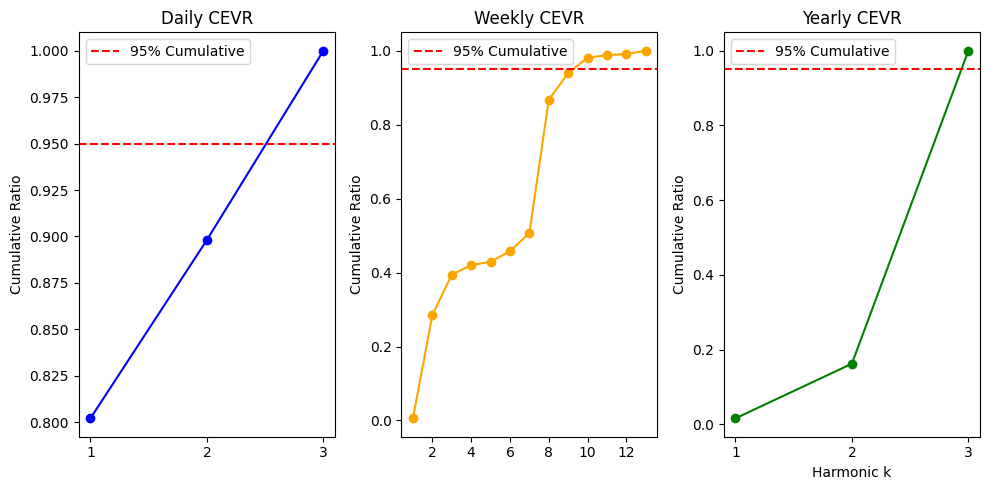

In [ ]:
from matplotlib.ticker import MaxNLocator

def extract_amplitude_phase(coef_block, K, label):
    results = []
    for k in range(K):
        a_k = coef_block[2 * k]
        b_k = coef_block[2 * k + 1]
        amplitude = np.sqrt(a_k**2 + b_k**2)
        phase_rad = np.arctan2(b_k, a_k)
        phase_deg = np.degrees(phase_rad)
        results.append({
            "Component": label,
            "Harmonic k": k + 1,
            "aₖ": round(a_k, 4),
            "bₖ": round(b_k, 4),
            "Amplitude": round(amplitude, 4),
            "Phase (rad)": round(phase_rad, 4),
            "Phase (deg)": round(phase_deg, 2)
        })
    return results

# 최적 K
Kd, Kw, Ky = 3,13,3
coef = best_model.coef_

# 계수 분할
daily_coef   = coef[:2 * Kd]
weekly_coef  = coef[2 * Kd : 2 * Kd + 2 * Kw]
yearly_coef  = coef[2 * Kd + 2 * Kw:]

# 해석 실행
daily_info  = extract_amplitude_phase(daily_coef,  Kd, "Daily")
weekly_info = extract_amplitude_phase(weekly_coef, Kw, "Weekly")
yearly_info = extract_amplitude_phase(yearly_coef, Ky, "Yearly")

# 결과 통합
seasonality_df = pd.DataFrame(daily_info + weekly_info + yearly_info)

# 시각 또는 테이블 출력

print(seasonality_df.to_string(index=False))

# 누적 설명력 계산

def confidential_test(data, component):
    # 필터링 
    data = data[data["Component"]==component]
    energy = data["aₖ"].values**2 + data["bₖ"].values**2

    total_energy = np.sum(energy)
    cumulative_ratio = np.cumsum(energy) / total_energy

    print("누적 설명력:", np.round(cumulative_ratio, 4))

    return np.round(cumulative_ratio, 4)

# 각각의 누적 설명력 시리즈 생성
daily = confidential_test(seasonality_df, "Daily")
weekly = confidential_test(seasonality_df, "Weekly")
yearly = confidential_test(seasonality_df, "Yearly")

# Subplot 설정 (1행 3열)
fig, axes = plt.subplots(1, 3, figsize=(10, 5), sharex=False)

# 공통: x축 눈금을 정수로 고정
for ax in axes:
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

# 1. Daily
axes[0].plot(np.arange(1, len(daily)+1), daily, marker='o', color='blue')
axes[0].axhline(y=0.95, color='r', linestyle='--', label='95% Cumulative')
axes[0].set_title("Daily CEVR")
axes[0].set_ylabel("Cumulative Ratio")
axes[0].legend()

# 2. Weekly
axes[1].plot(np.arange(1, len(weekly)+1), weekly, marker='o', color='orange')
axes[1].axhline(y=0.95, color='r', linestyle='--', label='95% Cumulative')
axes[1].set_title("Weekly CEVR")
axes[1].set_ylabel("Cumulative Ratio")
axes[1].legend()

# 3. Yearly
axes[2].plot(np.arange(1, len(yearly)+1), yearly, marker='o', color='green')
axes[2].axhline(y=0.95, color='r', linestyle='--', label='95% Cumulative')
axes[2].set_title("Yearly CEVR")
axes[2].set_xlabel("Harmonic k")
axes[2].set_ylabel("Cumulative Ratio")
axes[2].legend()

plt.tight_layout()
plt.show()

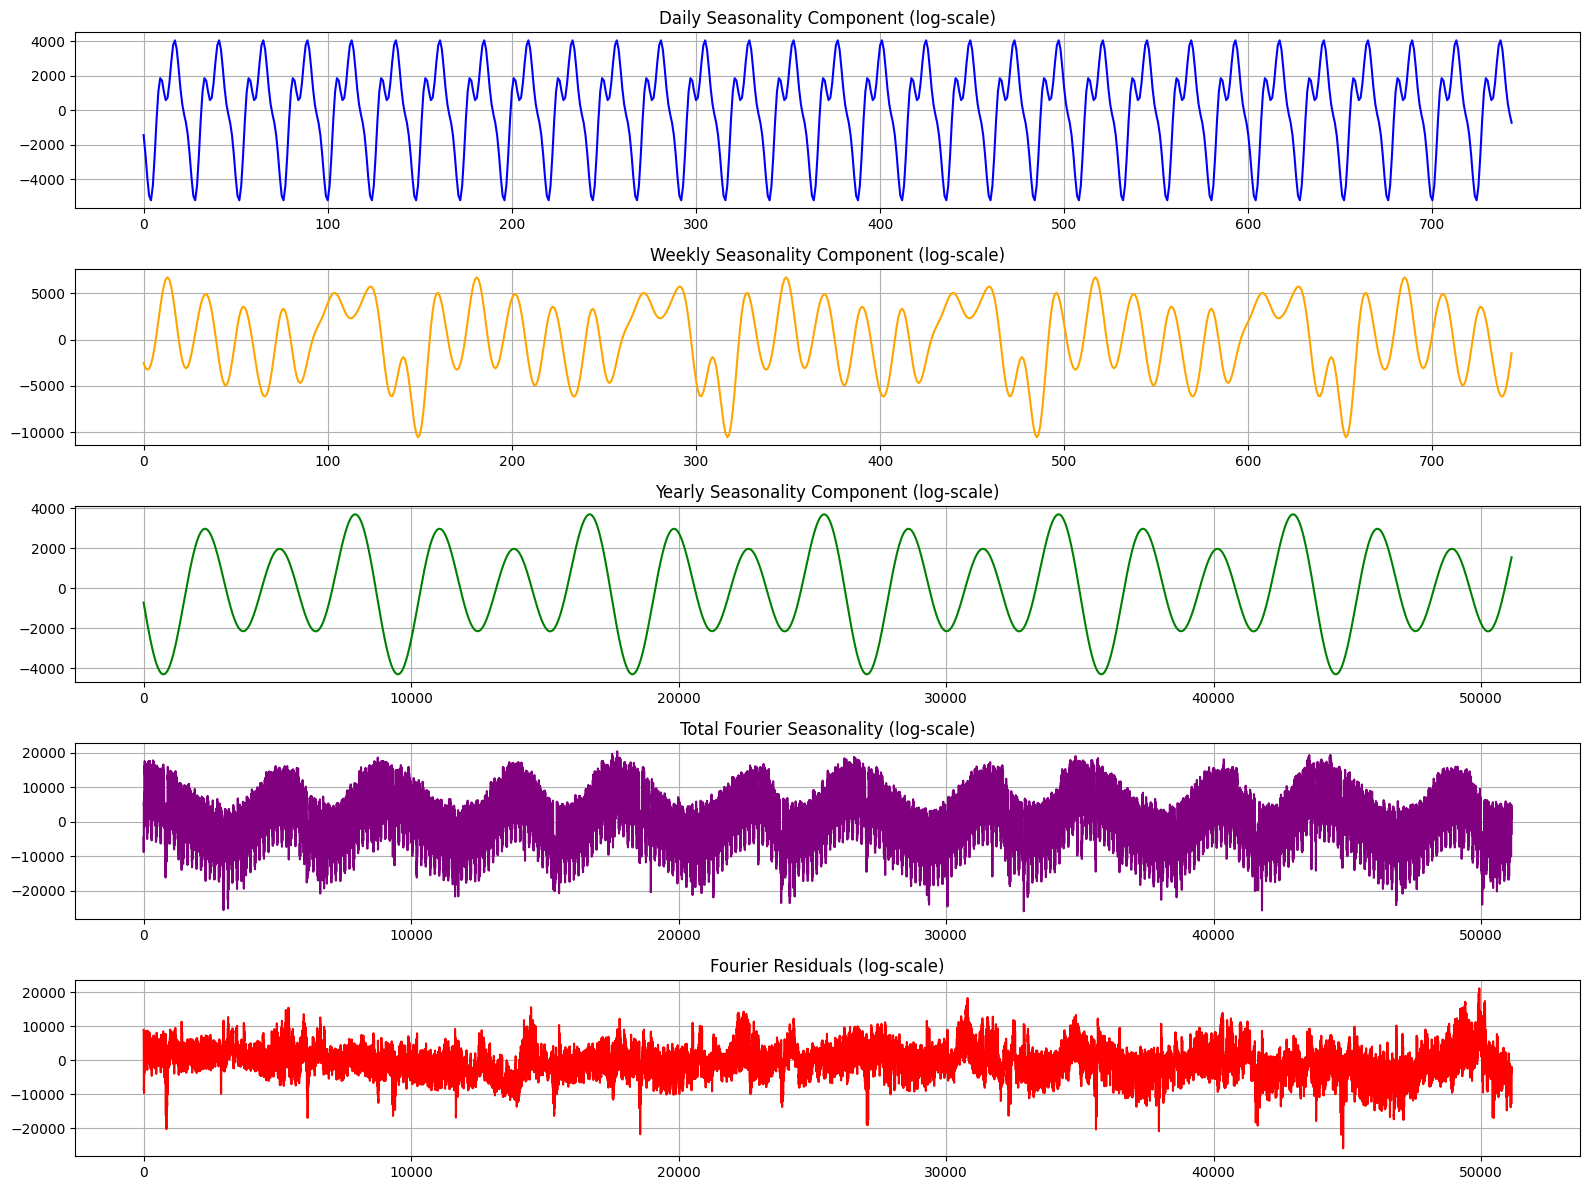

In [22]:
if "t" not in df.columns:
    df["t"] = np.arange(len(df))

df_result = df.copy()

Kd, Kw, Ky = 3,13,3 # 위 누적 설명률 플롯을 활용한 값 기반 반영

daily_terms  = generate_fourier_term(t_all, 24, Kd)        
weekly_terms = generate_fourier_term(t_all, 24*7, Kw)     
yearly_terms = generate_fourier_term(t_all, 24*365.25, Ky)

coef = best_model.coef_

n_daily  = 2 * Kd
n_weekly = 2 * Kw
n_yearly = 2 * Ky

idx_daily_end  = n_daily
idx_weekly_end = n_daily + n_weekly
idx_yearly_end = n_daily + n_weekly + n_yearly

coef_daily  = coef[:idx_daily_end]
coef_weekly = coef[idx_daily_end:idx_weekly_end]
coef_yearly = coef[idx_weekly_end:idx_yearly_end]

daily_pred_log  = daily_terms  @ coef_daily
weekly_pred_log = weekly_terms @ coef_weekly
yearly_pred_log = yearly_terms @ coef_yearly

seasonality_pred_log = best_model.predict(best_X_all)
residuals_log = y_all - seasonality_pred_log

df_result["Daily_Fourier"]   = daily_pred_log
df_result["Weekly_Fourier"]  = weekly_pred_log
df_result["Yearly_Fourier"]  = yearly_pred_log
df_result["Fourier_Seasonality"] = seasonality_pred_log
df_result["Fourier_Residual"] = residuals_log

plt.figure(figsize=(16, 12))

# 1. 일간 성분
plt.subplot(5, 1, 1)
plt.plot(df_result["t"][:24*31], daily_pred_log[:24*31], color='blue')
plt.title("Daily Seasonality Component (log-scale)")
plt.grid(True)

# 2. 주간 성분
plt.subplot(5, 1, 2)
plt.plot(df_result["t"][:24*31], weekly_pred_log[:24*31], color='orange')
plt.title("Weekly Seasonality Component (log-scale)")
plt.grid(True)

# 3. 연간 성분
plt.subplot(5, 1, 3)
plt.plot(df_result["t"], yearly_pred_log, color='green')
plt.title("Yearly Seasonality Component (log-scale)")
plt.grid(True)

# 4. 전체 Fourier seasonality
plt.subplot(5, 1, 4)
plt.plot(df_result["t"], df_result["Fourier_Seasonality"], color='purple')
plt.title("Total Fourier Seasonality (log-scale)")
plt.grid(True)

# 5. 잔차
plt.subplot(5, 1, 5)
plt.plot(df_result["t"], df_result["Fourier_Residual"], color='red')
plt.title("Fourier Residuals (log-scale)")
plt.grid(True)

plt.tight_layout()
plt.show()


In [23]:
## 이후 데이터셋 분할
train = df_result[df_result["일시"]<="2022-12-31 23:00:00"]
val = df_result[(df_result["일시"]>"2022-12-31 23:00:00") & (df["일시"]<="2023-12-31 23:00:00")]
test = df_result[df_result["일시"]>"2023-12-31 23:00:00"]

In [24]:
train

,일시,hm,ta,power demand(MW),holiday_name,weekday,weekend,spring,summer,autoum,...,is_holiday_dummies,trend,detrend,seasonality,t,Daily_Fourier,Weekly_Fourier,Yearly_Fourier,Fourier_Seasonality,Fourier_Residual
0,2019-01-01 00:00:00,59.705026,-4.174162,65388.0,New Year's Day,0,1,0,0,0,...,1,61004.231976,4383.768024,-4579.472553,0,-1445.864644,-2536.636985,-709.890722,-4579.472553,8963.240577
1,2019-01-01 01:00:00,60.096649,-4.349947,63045.0,New Year's Day,0,1,0,0,0,...,1,61004.329458,2040.670542,-6651.095339,1,-2562.908744,-3043.111459,-717.760607,-6651.095339,8691.765881
2,2019-01-01 02:00:00,61.854850,-4.491993,61036.0,New Year's Day,0,1,0,0,0,...,1,61004.426940,31.573060,-8099.965273,2,-3896.441744,-3247.459581,-725.628962,-8099.965273,8131.538333
3,2019-01-01 03:00:00,63.020635,-4.648325,59834.0,New Year's Day,0,1,0,0,0,...,1,61004.524422,-1170.524422,-8794.377751,3,-4961.417104,-3123.313957,-733.495758,-8794.377751,7623.853330
4,2019-01-01 04:00:00,63.784303,-4.722354,59491.0,New Year's Day,0,1,0,0,0,...,1,61004.621904,-1513.621904,-8495.357618,4,-5218.940666,-2659.086067,-741.360962,-8495.357618,6981.735714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35059,2022-12-31 19:00:00,66.365476,0.227351,67392.0,non-event,0,1,0,0,0,...,0,64519.381328,2872.618672,7094.013061,35059,2435.170156,2693.558034,-670.519466,7094.013061,-4221.394389
35060,2022-12-31 20:00:00,70.338988,-0.551577,66648.0,non-event,0,1,0,0,0,...,0,64519.484427,2128.515573,6697.822815,35060,1252.962405,3022.093584,-678.396524,6697.822815,-4569.307241
35061,2022-12-31 21:00:00,73.889286,-1.225030,65914.0,non-event,0,1,0,0,0,...,0,64519.587525,1394.412475,6002.194044,35061,336.843940,3418.660377,-686.272210,6002.194044,-4607.781569
35062,2022-12-31 22:00:00,76.481250,-1.560863,65739.0,non-event,0,1,0,0,0,...,0,64519.690624,1219.309376,4783.934296,35062,-245.602832,3863.269649,-694.146493,4783.934296,-3564.624921


## 딥러닝 코드 

In [50]:
from sklearn.preprocessing import StandardScaler

## 전처리 확인 코드
train_residual_x = train["Fourier_Residual"].values
val_residual_x = val["Fourier_Residual"].values
test_residual_x = test["Fourier_Residual"].values

train_residual_y = train["Fourier_Residual"].values
val_residual_y = val["Fourier_Residual"].values
test_residual_y = test["Fourier_Residual"].values

# 정규화 코드 - StandardScaler 사용
scaler_x = StandardScaler()
scaler_y = StandardScaler()

train_x = scaler_x.fit_transform(train_residual_x.reshape(-1, 1))
val_x = scaler_x.transform(val_residual_x.reshape(-1, 1))
test_x = scaler_x.transform(test_residual_x.reshape(-1, 1))

train_y = scaler_y.fit_transform(train_residual_y.reshape(-1, 1))
val_y = scaler_y.transform(val_residual_y.reshape(-1, 1))
test_y = scaler_y.transform(test_residual_y.reshape(-1, 1))

In [58]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import ParameterSampler
import time
import warnings
warnings.filterwarnings('ignore')


# ============================================================================
# UNIVARIATE SEQ2SEQ LSTM MODEL
# ============================================================================

class UnivariateSeq2SeqLSTM(nn.Module):
    """
    Univariate Encoder-Decoder LSTM
    
    Input: Single feature (power demand history)
    Output: Single target (power demand forecast)
    """
    
    def __init__(self, 
                 hidden_size=128, 
                 num_layers=2, 
                 dropout=0.2,
                 output_size=72,      # Forecast horizon (72 hours = 3 days)
                 bidirectional=False,
                 use_attention=False):
        super().__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        self.bidirectional = bidirectional
        self.use_attention = use_attention
        
        num_directions = 2 if bidirectional else 1
        
        # Encoder (input_size=1 for univariate)
        self.encoder = nn.LSTM(
            input_size=1,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0,
            batch_first=True,
            bidirectional=bidirectional
        )
        
        # Decoder (input_size=1, output_size=1)
        self.decoder = nn.LSTM(
            input_size=1,
            hidden_size=hidden_size * num_directions,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0,
            batch_first=True
        )
        
        # Attention
        if use_attention:
            self.attention = nn.Linear(hidden_size * num_directions * 2, 1)
        
        # Output layer (output 1 value)
        self.fc = nn.Linear(hidden_size * num_directions, 1)
        
    def forward(self, x, target=None, teacher_forcing_ratio=0.0):
        """
        Args:
            x: (batch, window_size, 1) - input sequence
            target: (batch, output_size, 1) - target sequence (for teacher forcing)
            teacher_forcing_ratio: probability of using teacher forcing (0.0 to 1.0)
        Returns:
            predictions: (batch, output_size, 1)
        """
        batch_size = x.size(0)
        
        # Encoder
        encoder_outputs, (hidden, cell) = self.encoder(x)
        
        if self.bidirectional:
            hidden = self._cat_directions(hidden)
            cell = self._cat_directions(cell)
        
        # Decoder initial input (zeros)
        decoder_input = torch.zeros(batch_size, 1, 1).to(x.device)
        
        outputs = []
        for t in range(self.output_size):
            if self.use_attention:
                decoder_output, (hidden, cell) = self.decoder(decoder_input, (hidden, cell))
                
                decoder_repeated = decoder_output.repeat(1, encoder_outputs.size(1), 1)
                combined = torch.cat([decoder_repeated, encoder_outputs], dim=2)
                attention_scores = self.attention(combined).squeeze(2)
                attention_weights = torch.softmax(attention_scores, dim=1)
                
                context = torch.bmm(attention_weights.unsqueeze(1), encoder_outputs)
                combined_output = decoder_output + context
                prediction = self.fc(combined_output)
            else:
                decoder_output, (hidden, cell) = self.decoder(decoder_input, (hidden, cell))
                prediction = self.fc(decoder_output)
            
            outputs.append(prediction)
            
            # Teacher forcing: use target or prediction as next input
            if target is not None and torch.rand(1).item() < teacher_forcing_ratio:
                decoder_input = target[:, t:t+1, :]  # Use ground truth
            else:
                decoder_input = prediction  # Use own prediction
        
        return torch.cat(outputs, dim=1)
    
    def _cat_directions(self, h):
        return torch.cat([h[0::2], h[1::2]], dim=2)


# ============================================================================
# TRAINING UTILITIES
# ============================================================================

class EarlyStopping:
    def __init__(self, patience=10, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        
    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0


def train_model(model, train_loader, val_loader, config, verbose=True):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    
    criterion = nn.MSELoss()
    teacher_forcing_ratio = config.get('teacher_forcing_ratio', 0.0)
    
    # Optimizer
    if config['optimizer'] == 'adam':
        optimizer = torch.optim.Adam(
            model.parameters(), 
            lr=config['learning_rate'],
            weight_decay=config['weight_decay']
        )
    elif config['optimizer'] == 'adamw':
        optimizer = torch.optim.AdamW(
            model.parameters(), 
            lr=config['learning_rate'],
            weight_decay=config['weight_decay']
        )
    elif config['optimizer'] == 'sgd':
        optimizer = torch.optim.SGD(
            model.parameters(), 
            lr=config['learning_rate'],
            momentum=0.9,
            weight_decay=config['weight_decay']
        )
    
    # Scheduler
    if config['scheduler'] == 'step':
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
    elif config['scheduler'] == 'cosine':
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=config['epochs'])
    elif config['scheduler'] == 'reduce':
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)
    else:
        scheduler = None
    
    early_stopping = EarlyStopping(patience=config['early_stopping_patience'])
    best_val_loss = float('inf')
    
    if verbose:
        print(f"\n{'Epoch':>5} {'Train Loss':>12} {'Val Loss':>12} {'Best Val':>12} {'Status':>10}", flush=True)
        print("-" * 65, flush=True)
    
    for epoch in range(config['epochs']):
        # Training
        model.train()
        train_loss = 0
        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            
            optimizer.zero_grad()
            predictions = model(batch_x, target=batch_y, teacher_forcing_ratio=teacher_forcing_ratio)
            loss = criterion(predictions, batch_y)
            loss.backward()
            
            if config['grad_clip'] > 0:
                torch.nn.utils.clip_grad_norm_(model.parameters(), config['grad_clip'])
            
            optimizer.step()
            train_loss += loss.item()
        
        train_loss /= len(train_loader)
        
        # Validation (no teacher forcing)
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch_x, batch_y in val_loader:
                batch_x, batch_y = batch_x.to(device), batch_y.to(device)
                predictions = model(batch_x, target=None, teacher_forcing_ratio=0.0)
                loss = criterion(predictions, batch_y)
                val_loss += loss.item()
        
        val_loss /= len(val_loader)
        
        # Update best
        status = ""
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            status = "✓ Best"
        
        # Print epoch results
        if verbose:
            print(f"{epoch+1:5d} {train_loss:12.6f} {val_loss:12.6f} {best_val_loss:12.6f} {status:>10}", flush=True)
        
        # Scheduler
        if scheduler is not None:
            if config['scheduler'] == 'reduce':
                scheduler.step(val_loss)
            else:
                scheduler.step()
        
        # Early stopping
        early_stopping(val_loss)
        if early_stopping.early_stop:
            if verbose:
                print(f"\nEarly stopping at epoch {epoch+1}", flush=True)
            break
    
    return best_val_loss


# ============================================================================
# HYPERPARAMETER TUNING
# ============================================================================

class UnivariateSeq2SeqTuner:
    """
    Hyperparameter tuning for Univariate Seq2Seq LSTM with non-overlapping windows
    """
    
    def __init__(self, window_size=168, horizon=72, random_state=42):
        self.window_size = window_size
        self.horizon = horizon
        self.random_state = random_state
        
        # Hyperparameter search space
        self.param_distributions = {
            # Model architecture
            'hidden_size': [64, 128, 256],
            'num_layers': [2, 3],
            'dropout': [0.1, 0.2, 0.3],
            'bidirectional': [False, True],
            'use_attention': [False, True],
            
            # Training
            'batch_size': [32, 64],
            'learning_rate': [0.0005, 0.001, 0.005],
            'optimizer': ['adamw'],
            'weight_decay': [0.0, 1e-4],
            'grad_clip': [0.5, 1.0],
            'teacher_forcing_ratio': [0.0, 0.3, 0.5, 0.7],  # NEW: Teacher forcing
            
            # Regularization
            'scheduler': ['cosine', 'reduce'],
            'early_stopping_patience': [10, 15],
            
            # Data preprocessing
            'scaler': ['standard'],
        }
        
        self.best_params = None
        self.best_score = float('inf')
        self.results = []
        
    def create_non_overlapping_windows(self, y_data):
        """
        Create non-overlapping sliding windows (stride = horizon)
        
        Args:
            y_data: Series or numpy array with target values (univariate)
            
        Returns:
            X: (N, window_size, 1) - input sequences
            y: (N, horizon, 1) - target sequences
        """
        # Convert to numpy array if pandas Series
        if isinstance(y_data, pd.Series):
            y_values = y_data.values
        else:
            y_values = np.array(y_data)
        
        stride = self.horizon  # Non-overlapping: stride = 24
        
        X_windows = []
        y_windows = []
        
        # Create non-overlapping windows
        for i in range(0, len(y_values) - self.window_size - self.horizon + 1, stride):
            X_windows.append(y_values[i:i+self.window_size])
            y_windows.append(y_values[i+self.window_size:i+self.window_size+self.horizon])
        
        X = np.array(X_windows).reshape(-1, self.window_size, 1)  # (N, 168, 1)
        y = np.array(y_windows).reshape(-1, self.horizon, 1)       # (N, 24, 1)
        
        return X, y
    
    def create_dataloaders(self, train_y, val_y, config, apply_scaling=False):
        """
        Create DataLoaders from train/val data with non-overlapping windows
        
        Args:
            apply_scaling: If True, apply scaling internally. 
                          If False (default), assume data is already scaled.
        """
        print("Creating non-overlapping sliding windows...")
        
        # Create windows (stride=horizon, non-overlapping)
        X_train, y_train = self.create_non_overlapping_windows(train_y)
        X_val, y_val = self.create_non_overlapping_windows(val_y)
        
        print(f"  Train windows: {len(X_train)} (non-overlapping, stride={self.horizon})")
        print(f"  Val windows: {len(X_val)} (non-overlapping, stride={self.horizon})")
        print(f"  X shape: {X_train.shape} (batch, window={self.window_size}, features=1)")
        print(f"  y shape: {y_train.shape} (batch, horizon={self.horizon}, output=1)")
        
        # Scaling (optional)
        scaler = None
        if apply_scaling:
            print(f"  Applying {config['scaler']} scaling...")
            if config['scaler'] == 'standard':
                scaler = StandardScaler()
            elif config['scaler'] == 'minmax':
                scaler = MinMaxScaler()
            else:
                scaler = RobustScaler()
            
            # Reshape for scaling: (N, W, 1) → (N*W, 1) → scale → reshape back
            N_train, W, F = X_train.shape
            X_train_reshaped = X_train.reshape(-1, 1)
            X_train_scaled = scaler.fit_transform(X_train_reshaped).reshape(N_train, W, F)
            
            N_val = X_val.shape[0]
            X_val_reshaped = X_val.reshape(-1, 1)
            X_val_scaled = scaler.transform(X_val_reshaped).reshape(N_val, W, F)
            
            # Scale y (same scaler)
            y_train_reshaped = y_train.reshape(-1, 1)
            y_train_scaled = scaler.transform(y_train_reshaped).reshape(N_train, self.horizon, 1)
            
            y_val_reshaped = y_val.reshape(-1, 1)
            y_val_scaled = scaler.transform(y_val_reshaped).reshape(N_val, self.horizon, 1)
        else:
            print("  Using pre-scaled data (no additional scaling)")
            X_train_scaled = X_train
            y_train_scaled = y_train
            X_val_scaled = X_val
            y_val_scaled = y_val
        
        # To tensors
        X_train_t = torch.FloatTensor(X_train_scaled)
        y_train_t = torch.FloatTensor(y_train_scaled)
        
        X_val_t = torch.FloatTensor(X_val_scaled)
        y_val_t = torch.FloatTensor(y_val_scaled)
        
        # DataLoaders
        train_dataset = TensorDataset(X_train_t, y_train_t)
        val_dataset = TensorDataset(X_val_t, y_val_t)
        
        train_loader = DataLoader(
            train_dataset, 
            batch_size=config['batch_size'], 
            shuffle=True
        )
        val_loader = DataLoader(
            val_dataset, 
            batch_size=config['batch_size'], 
            shuffle=False
        )
        
        return train_loader, val_loader, scaler
    
    def random_search(self, train_y, val_y, n_iter=50, epochs=50, apply_scaling=False):
        """
        Random Search for hyperparameter tuning (univariate, non-overlapping)
        
        Args:
            train_y: Series or numpy array with training targets (power demand)
            val_y: Series or numpy array with validation targets
            n_iter: Number of random configurations
            epochs: Max epochs per trial
            apply_scaling: If True, apply scaling internally. If False (default), 
                          assumes data is already scaled externally.
        """
        print("=" * 80)
        print("UNIVARIATE SEQ2SEQ LSTM HYPERPARAMETER TUNING (NON-OVERLAPPING)")
        print("=" * 80)
        print(f"\nData info:")
        print(f"  Train samples: {len(train_y)}")
        print(f"  Val samples: {len(val_y)}")
        print(f"  Input: Univariate (power demand only)")
        print(f"\nWindow size: {self.window_size} hours (7 days)")
        print(f"Horizon: {self.horizon} hours (3 days)")
        print(f"Window strategy: Non-overlapping (stride={self.horizon})")
        print(f"\nRandom search iterations: {n_iter}")
        print(f"Max epochs per trial: {epochs}\n")
        
        # Random search
        sampler = ParameterSampler(
            self.param_distributions, 
            n_iter=n_iter, 
            random_state=self.random_state
        )
        
        for i, params in enumerate(sampler):
            print(f"\n{'='*80}")
            print(f"Trial {i+1}/{n_iter}")
            print(f"{'='*80}")
            print(f"Parameters:")
            for key, value in params.items():
                print(f"  {key:25s}: {value}")
            
            try:
                # Create dataloaders
                config = {**params, 'epochs': epochs}
                train_loader, val_loader, scaler = \
                    self.create_dataloaders(train_y, val_y, config, apply_scaling=apply_scaling)
                
                # Create model
                model = UnivariateSeq2SeqLSTM(
                    hidden_size=params['hidden_size'],
                    num_layers=params['num_layers'],
                    dropout=params['dropout'],
                    output_size=self.horizon,
                    bidirectional=params['bidirectional'],
                    use_attention=params['use_attention']
                )
                
                n_params = sum(p.numel() for p in model.parameters())
                print(f"\nModel parameters: {n_params:,}")
                
                # Train
                start_time = time.time()
                val_loss = train_model(model, train_loader, val_loader, config)
                training_time = time.time() - start_time
                
                print(f"\nValidation Loss: {val_loss:.6f}")
                print(f"Training time: {training_time:.1f}s")
                
                # Save results
                result = {
                    'trial': i + 1,
                    'params': params.copy(),
                    'val_loss': val_loss,
                    'n_params': n_params,
                    'training_time': training_time
                }
                self.results.append(result)
                
                # Update best
                if val_loss < self.best_score:
                    self.best_score = val_loss
                    self.best_params = params.copy()
                    self.best_model_state = model.state_dict()
                    self.best_scaler = scaler
                    print(f"\n🎯 New best model! Val Loss: {val_loss:.6f}")
                
            except Exception as e:
                print(f"\n❌ Trial failed: {str(e)}")
                import traceback
                traceback.print_exc()
                continue
        
        self._print_summary()
        
        return self.best_params, self.best_score
    
    def _print_summary(self):
        print("\n" + "=" * 80)
        print("HYPERPARAMETER TUNING SUMMARY")
        print("=" * 80)
        
        if not self.results:
            print("No successful trials!")
            return
        
        sorted_results = sorted(self.results, key=lambda x: x['val_loss'])
        
        print(f"\nTop 5 configurations:")
        print("-" * 80)
        for i, result in enumerate(sorted_results[:5]):
            print(f"\nRank {i+1}:")
            print(f"  Val Loss: {result['val_loss']:.6f}")
            print(f"  Params: {result['n_params']:,}")
            print(f"  Time: {result['training_time']:.1f}s")
            print(f"  Config:")
            for key, value in result['params'].items():
                print(f"    {key:25s}: {value}")
        
        print("\n" + "=" * 80)
        print("BEST PARAMETERS:")
        print("=" * 80)
        for key, value in self.best_params.items():
            print(f"  {key:25s}: {value}")
        print(f"\nBest Validation Loss: {self.best_score:.6f}")
        print("=" * 80)
    
    def get_results_df(self):
        if not self.results:
            return None
        
        records = []
        for result in self.results:
            record = {
                'trial': result['trial'],
                'val_loss': result['val_loss'],
                'n_params': result['n_params'],
                'training_time': result['training_time']
            }
            record.update(result['params'])
            records.append(record)
        
        return pd.DataFrame(records)


# ============================================================================
# EXAMPLE USAGE
# ============================================================================

if __name__ == "__main__":
    # Example: Load your data
    # train_y: pandas Series with power demand (training set)
    # val_y: pandas Series with power demand (validation set)
    # test_y: pandas Series with power demand (test set)

    
    print(f"\nDataset split:")
    print(f"  Train: {len(train_y)} samples")
    print(f"  Val:   {len(val_y)} samples")
    print(f"  Test:  {len(test_y)} samples")
    
    # Initialize tuner
    tuner = UnivariateSeq2SeqTuner(
        window_size=168,  # 7 days
        horizon=24,       # 1 day
        random_state=42
    )
    
    # Run random search
    best_params, best_score = tuner.random_search(
        train_y=train_y,
        val_y=val_y,
        n_iter=12,  # 10 trials for demo
        epochs=10
    )
    
    # Get results as DataFrame
    results_df = tuner.get_results_df()
    if results_df is not None:
        print("\n" + "=" * 80)
        print("RESULTS DATAFRAME:")
        print("=" * 80)
        print(results_df.sort_values('val_loss').head())
    
    # Save best model
    torch.save(tuner.best_model_state, 'best_univariate_seq2seq_model.pth')
    print("\n✅ Best model saved to 'best_univariate_seq2seq_model.pth'")


Dataset split:
  Train: 35064 samples
  Val:   8760 samples
  Test:  7320 samples
UNIVARIATE SEQ2SEQ LSTM HYPERPARAMETER TUNING (NON-OVERLAPPING)

Data info:
  Train samples: 35064
  Val samples: 8760
  Input: Univariate (power demand only)

Window size: 168 hours (7 days)
Horizon: 24 hours (3 days)
Window strategy: Non-overlapping (stride=24)

Random search iterations: 12
Max epochs per trial: 10


Trial 1/12
Parameters:
  weight_decay             : 0.0
  use_attention            : True
  teacher_forcing_ratio    : 0.3
  scheduler                : cosine
  scaler                   : standard
  optimizer                : adamw
  num_layers               : 3
  learning_rate            : 0.0005
  hidden_size              : 64
  grad_clip                : 1.0
  early_stopping_patience  : 10
  dropout                  : 0.2
  bidirectional            : True
  batch_size               : 64
Creating non-overlapping sliding windows...
  Train windows: 1454 (non-overlapping, stride=24)
  Val 

In [70]:
def predict_test(model, test_y, window_size, horizon, scaler=None):
    """
    Run inference on test data (non-overlapping windows).
    
    Args:
        model: trained Seq2Seq model (in eval mode)
        test_y: pandas Series or array of test targets
        window_size: look-back window size (e.g., 168)
        horizon: forecast horizon (e.g., 72)
        scaler: fitted scaler (optional)
        
    Returns:
        predictions: numpy array (N, horizon)
        targets: numpy array (N, horizon)
    """
    model.eval()
    device = next(model.parameters()).device
    
    # Convert windows
    tuner = UnivariateSeq2SeqTuner(window_size, horizon)
    X_test, y_test = tuner.create_non_overlapping_windows(test_y)
    
    # Scaling
    if scaler is not None:
        N, W, _ = X_test.shape
        X_test = scaler.transform(X_test.reshape(-1,1)).reshape(N, W, 1)
        y_test = scaler.transform(y_test.reshape(-1,1)).reshape(N, horizon, 1)

    X_test_t = torch.FloatTensor(X_test).to(device)
    
    preds = []
    with torch.no_grad():
        for i in range(X_test_t.shape[0]):
            x = X_test_t[i:i+1]
            pred = model(x, target=None, teacher_forcing_ratio=0.0)
            preds.append(pred.cpu().numpy())
    
    preds = np.vstack(preds)
    
    # Inverse transform if scaler exists
    if scaler is not None:
        preds = scaler.inverse_transform(preds.reshape(-1, 1)).reshape(-1, horizon, 1)
        y_test = scaler.inverse_transform(y_test.reshape(-1, 1)).reshape(-1, horizon, 1)
    
    return preds.squeeze(), y_test.squeeze()


In [71]:
device = "cuda"

# 1) 모델 로드
best_model = UnivariateSeq2SeqLSTM(
    hidden_size=tuner.best_params['hidden_size'],
    num_layers=tuner.best_params['num_layers'],
    dropout=tuner.best_params['dropout'],
    output_size=tuner.horizon,
    bidirectional=tuner.best_params['bidirectional'],
    use_attention=tuner.best_params['use_attention']
)

best_model.load_state_dict(torch.load('best_univariate_seq2seq_model.pth'))
best_model.to(device)

# 2) Test prediction
preds, targets = predict_test(
    model=best_model,
    test_y=test_y,
    window_size=tuner.window_size,
    horizon=tuner.horizon,
    scaler=tuner.best_scaler
)

print("Pred shape:", preds.shape)   # (N, horizon)
print("True shape:", targets.shape) # (N, horizon)


Pred shape: (298, 24)
True shape: (298, 24)


In [75]:
# scaler_x = StandardScaler()
# scaler_y = StandardScaler()
 

def plot_multistep_forecast(preds, targets, horizon, title="Multi-step Forecast"):
    """
    preds   : (N, horizon)
    targets : (N, horizon)
    horizon : int (forecast horizon)
    """
    N = preds.shape[0]
    pred_series = preds.reshape(-1)
    target_series = targets.reshape(-1)

    # 위 예측 및 실제값을 역정규화
    invverse_pred = scaler_y.inverse_transform(pred_series.reshape(-1, 1)).reshape(-1)
    invverse_target = scaler_y.inverse_transform(target_series.reshape(-1, 1)).reshape(-1)

    plt.figure(figsize=(18,5))
    plt.plot(invverse_target, label="True", linewidth=2)
    plt.plot(invverse_pred, label="Forecast", linewidth=2, alpha=0.5)
    plt.title(title, fontsize=16)
    plt.xlabel("Time step")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True)
    plt.show()

    # 출력값 생성을 return으로 제시
    return invverse_pred, invverse_target

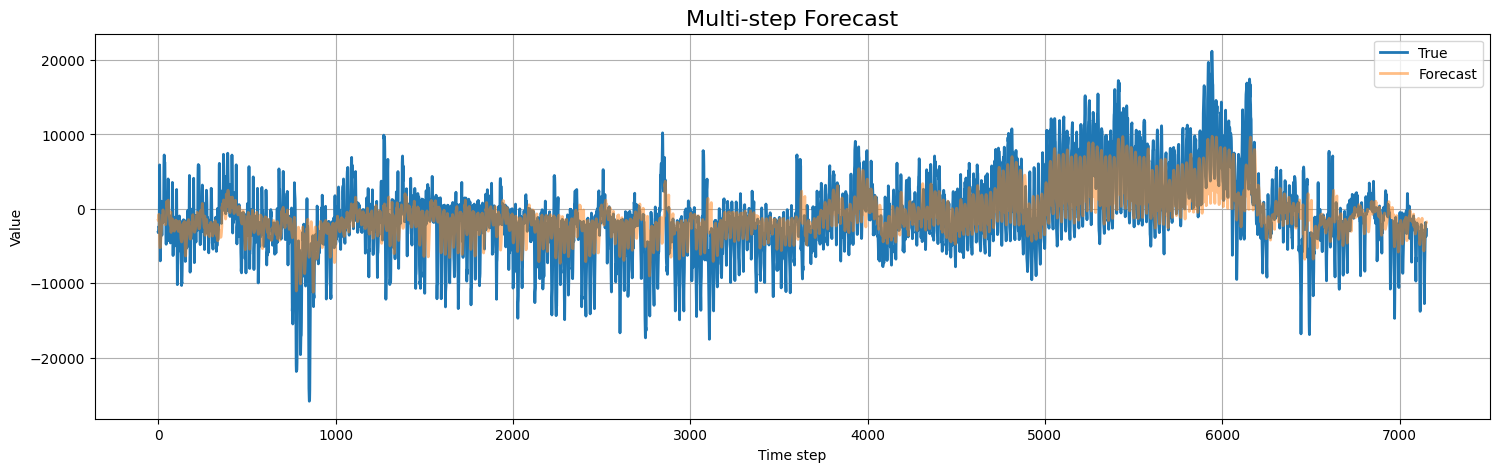

In [76]:
target_inverse, pred_invese = plot_multistep_forecast(preds, targets, horizon=tuner.horizon)

## 추세 + 다중계절성 + 잔차 예측한 부분 값 생성하여 결과 출력

In [79]:
print(len(test))
print(len(pred_invese))

7320
7152


In [84]:
forecast = test["trend"][-len(pred_invese):] + test["Fourier_Seasonality"][-len(pred_invese):] + target_inverse

In [85]:
pred_invese

array([-3154.32276141, -3221.7501343 , -2664.23279331, ...,
       -3733.66254707, -3038.1662682 , -2778.37363546], shape=(7152,))

In [ ]:
forecast.valuies

43992    65707.030281
43993    63335.139050
43994    62082.068243
43995    61846.660103
43996    62554.613680
             ...     
51139    67756.843201
51140    66669.918792
51141    65216.289378
51142    63270.700204
51143    60898.705667
Length: 7152, dtype: float64

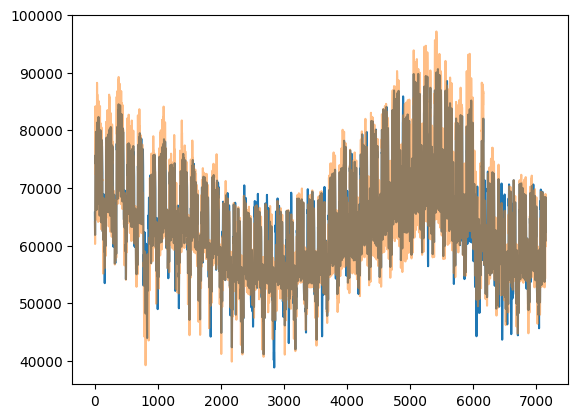

{'MAE: 2484.8792, MSE: 11732227.6395, R2: 0.8915, SMAPE: 3.8968, MAPE: 0.0393'}

In [ ]:
plt.plot(forecast.values)
plt.plot(test["power demand(MW)"][-len(pred_invese):].values, alpha=0.5)
plt.show()

# smape 결과 출력 함수
def smape(y_true, y_pred):
    """
    Symmetric Mean Absolute Percentage Error
    y_true, y_pred shape: (N, horizon) or (N, horizon, 1)
    """
    y_true = np.array(y_true).reshape(-1)
    y_pred = np.array(y_pred).reshape(-1)
    
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    diff = np.abs(y_true - y_pred)
    
    # Avoid division by zero
    mask = denominator == 0
    denominator[mask] = 1
    diff[mask] = 0
    
    return np.mean(diff / denominator) * 100

# 평가지표 확인
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
def get_metrics(y_true, y_pred):
    mae  = mean_absolute_error(y_true, y_pred)
    mse  = mean_squared_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)
    smape_val = smape(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)

    return {f"MAE: {mae:.4f}, MSE: {mse:.4f}, R2: {r2:.4f}, SMAPE: {smape_val:.4f}, MAPE: {mape:.4f}"}

# 호출
get_metrics(targets, preds)

# 출력
target1 = test["power demand(MW)"][-len(pred_invese):].values
pred = forecast.values
get_metrics(target1, pred)